<a href="https://colab.research.google.com/github/tianchu-shu/NWMSS/blob/main/Classification_of_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Section 1: Load the Data

In [ ]:
#Data saved in csv/excel
import glob, os

data_dir= '/content/gdrive/My Drive/data (1)/'
os.chdir(data_dir)

In [ ]:
!ls

 ARMADA_TBSCORES_MAY2020.csv			'Classification of MCI.ipynb'
'armada_tbscores_may2020 data dictionary.xlsx'	 foo.csv
 armada_tbscores_may2020.sas7bdat		 functions.R
 armada_uds_nov20_di.sas7bdat			 mci_classification.Rmd


In [ ]:
raw= pd.read_csv("ARMADA_TBSCORES_MAY2020.csv")
raw.shape

(1083, 189)

# Section 2: Data Cleaning

In [ ]:
#Only keep the rows with assmnt = 1
df = raw[raw.assmnt==1]

In [ ]:
df.shape

(817, 189)

In [ ]:
#Only keeping the columns for cognition
df = df.iloc[:, :69 ]

In [ ]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,racetb_b,racetb_as,racetb_ai,racetb_nhpi,racetb_oth,racetb_no,race_toolbox,EDUCATION,HANDEDNESS,CCC_ACSScore,CCC_FCTScore,CCC_UCSScore,CFC_ACSScore,CFC_FCTScore,CFC_UCSScore,CTC_ACSScore,CTC_FCTScore,CTC_UCSScore,DCCS_ACSScore,DCCS_CScore,DCCS_FCTScore,DCCS_Raw,DCCS_UCSScore,Flanker_ACSScore,Flanker_CScore,Flanker_FCTScore,Flanker_Raw,Flanker_UCSScore,FNAMEFNF_Raw,FNAMEFNL_Raw,FNAMEFNM_Raw,FNAMEFSB_Raw,FNAMESum_Raw,LSWM_ACSScore,LSWM_FCTScore,LSWM_Raw,LSWM_UCSScore,ORR_ACSScore,ORR_FCTScore,ORR_SE,ORR_Theta,ORR_UCSScore,PCPS_ACSScore,PCPS_CScore,PCPS_FCTScore,PCPS_Raw,PCPS_UCSScore,PSM_ACSScore,PSM_CScore,PSM_FCTScore,PSM_Raw,PSM_SE,PSM_Theta,PSM_UCSScore,TPVT_ACSScore,TPVT_FCTScore,TPVT_SE,TPVT_Theta,TPVT_UCSScore
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,1,0,0,0,0,0,2.0,22.0,1,83.0,36.0,95.0,90.0,43.0,75.0,85.0,38.0,81.0,95.0,6.14,41.0,26.0,86.0,86.0,6.40,41.0,20.0,81.0,NaN,NaN,NaN,NaN,NaN,94.0,45.0,12.0,82.0,78.0,35.0,9.900,-0.900,89.0,87.0,34.0,47.0,31.0,74.0,106.0,424.77,52.0,7.0,0.32,-1.152,93.0,93.0,39.0,0.495,4.061,102.0
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,0,0,0,0,0,0,1.0,21.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,13.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482,4.834,105.0
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,0,0,0,0,0,0,1.0,21.0,2,NaN,NaN,113.0,NaN,NaN,81.0,NaN,NaN,96.0,NaN,7.51,NaN,28.0,98.0,NaN,7.18,NaN,20.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,94.0,NaN,NaN,0.470,7.335,113.0,NaN,38.0,NaN,33.0,78.0,NaN,340.97,NaN,1.0,0.41,-1.990,79.0,NaN,NaN,0.493,6.309,112.0
5,1.46931,1,Emory,6,en-US,73,2,1,2,0,1,0,0,0,0,0,2.0,21.0,1,93.0,48.0,103.0,86.0,41.0,79.0,87.0,43.0,88.0,89.0,6.43,39.0,28.0,89.0,82.0,6.47,39.0,20.0,82.0,NaN,NaN,NaN,NaN,NaN,105.0,57.0,16.0,97.0,90.0,46.0,0.481,2.744,100.0,75.0,31.0,37.0,29.0,69.0,101.0,418.40,48.0,6.0,0.33,-1.216,92.0,97.0,49.0,0.465,4.953,106.0
6,1.47476,1,Emory,3,en-US,66,1,1,2,0,1,0,0,0,0,0,2.0,22.0,1,121.0,62.0,118.0,78.0,38.0,79.0,100.0,50.0,97.0,85.0,6.42,32.0,30.0,89.0,78.0,6.86,42.0,20.0,86.0,NaN,NaN,NaN,NaN,NaN,90.0,46.0,14.0,90.0,122.0,64.0,0.474,8.486,116.0,78.0,34.0,39.0,31.0,74.0,97.0,424.77,52.0,7.0,0.32,-1.150,93.0,116.0,58.0,0.490,7.292,117.0


In [ ]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [ ]:
 df['cohort2'] = df['cohort2'].map(cohort)

In [ ]:
df.AGE.max()

99

In [ ]:
df.cohort2.value_counts()

Gen population 65-85                          161
Gen population healthy aging 85+              115
Spanish Speaking normal controls 65-85        107
Spanish Speaking mild cognitive impairment    104
Gen population MCI                            104
African American normal controls 65-85         94
Gen population AD                              71
African American mild cognitive impairment     38
Spanish Speaking AD                            23
Name: cohort2, dtype: int64

In [ ]:
cohort_groups =["Gen population 65-85", "Gen population MCI",
             "Gen population AD","Gen population healthy aging 85+",
               "Spanish Speaking mild cognitive impairment",
                                           "Spanish Speaking normal controls 65-85", "Spanish Speaking AD"]

In [ ]:
#To select rows whose column value is in cohort_groups
#df =df[df.cohort2.isin(cohort_groups)]

In [ ]:
edu={1:"None",
2 :"Less than HS",
3 :"Less than HS",
4 :"Less than HS",
5 :"Less than HS",
6 :"Less than HS",
7 :"Less than HS",
8 :"Less than HS",
9 :"Less than HS",
10 :"Less than HS",
11 :"Less than HS",
12 :"Less than HS",
13 :"Less than HS",
14 :"Less than HS",
16 :"High School",
18 :"Some College",
20 :"Some College",
21 :"College Degree",
22 :"Graduate Degree",
23 :"Graduate Degree",
24 :"Graduate Degree",
25 :"Some College",
26 :"Some College",
27 :"Some College",
28 :"None",
999:"Unknown"}

In [ ]:
 df['EDUCATION'] = df['EDUCATION'].map(edu)

In [ ]:
#Create new columns cohort_groups, cognitive_status
df.loc[df['cohort2'].str.contains('Gen population'), 'cohort_group'] = 'GenPop'
df.loc[df['cohort2'].str.contains('Spanish'), 'cohort_group'] = 'Spanish'
df.loc[df['cohort2'].str.contains('African American'), 'cohort_group'] = 'AA'

In [ ]:
df.shape

(817, 70)

In [ ]:
df.cohort_group.value_counts()

GenPop     451
Spanish    234
AA         132
Name: cohort_group, dtype: int64

In [ ]:
#Create new columns cohort_groups, cognitive_status
df.loc[df['cohort2'].str.contains('mild cognitive impairment|MCI'), 'cognitive_status'] = 'MCI'
df.loc[df['cohort2'].str.contains('AD'), 'cognitive_status'] = 'AD'
df.loc[df['cohort2'].str.contains('65-85|normal controls|healthy aging 85+'), 'cognitive_status'] = 'NC'
df['cognitive_status'].head()

0     NC
1     AD
3    MCI
5     NC
6    MCI
Name: cognitive_status, dtype: object

In [ ]:
df['SEX'] = df['gender_rc']-1

In [ ]:
df.columns

Index(['ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE', 'gender_rc',
       'ethnicity_rc', 'race_tb_rc', 'racetb_w', 'racetb_b', 'racetb_as',
       'racetb_ai', 'racetb_nhpi', 'racetb_oth', 'racetb_no', 'race_toolbox',
       'EDUCATION', 'HANDEDNESS', 'CCC_ACSScore', 'CCC_FCTScore',
       'CCC_UCSScore', 'CFC_ACSScore', 'CFC_FCTScore', 'CFC_UCSScore',
       'CTC_ACSScore', 'CTC_FCTScore', 'CTC_UCSScore', 'DCCS_ACSScore',
       'DCCS_CScore', 'DCCS_FCTScore', 'DCCS_Raw', 'DCCS_UCSScore',
       'Flanker_ACSScore', 'Flanker_CScore', 'Flanker_FCTScore', 'Flanker_Raw',
       'Flanker_UCSScore', 'FNAMEFNF_Raw', 'FNAMEFNL_Raw', 'FNAMEFNM_Raw',
       'FNAMEFSB_Raw', 'FNAMESum_Raw', 'LSWM_ACSScore', 'LSWM_FCTScore',
       'LSWM_Raw', 'LSWM_UCSScore', 'ORR_ACSScore', 'ORR_FCTScore', 'ORR_SE',
       'ORR_Theta', 'ORR_UCSScore', 'PCPS_ACSScore', 'PCPS_CScore',
       'PCPS_FCTScore', 'PCPS_Raw', 'PCPS_UCSScore', 'PSM_ACSScore',
       'PSM_CScore', 'PSM_FCTScore', 'PSM_Raw', 'PSM

# Refereneces

Two sets of regressions (like in A and B below) for three comparisons (Ad vs mci, mc vs nc, nc vs AD) and three race/ethnicity. And an overall (with all the race/ethnicities collapsed)

A) AD vs. MCI = CCC + CFC  + age + sex + education



In [ ]:
var1_acs= ['cohort_group', 'cognitive_status','AGE','SEX', 'College Degree', 'Graduate Degree', 'High School', 'Less than HS',
        'None', 'Some College','CCC_ACSScore','CFC_ACSScore']

In [ ]:
var1_fct= ['cohort_group', 'cognitive_status','AGE','SEX', 'College Degree', 'Graduate Degree', 'High School', 'Less than HS',
        'None', 'Some College','CCC_FCTScore','CFC_FCTScore']

In [ ]:
var1_ucs= ['cohort_group', 'cognitive_status','AGE','SEX', 'College Degree', 'Graduate Degree', 'High School', 'Less than HS',
        'None', 'Some College','CCC_UCSScore','CFC_UCSScore']

[ROC Curves, confusion matrix](https://scikit-plot.readthedocs.io/en/stable/metrics.html)

In [ ]:
!pip3 install scikit-plot

In [ ]:
def dummy_variable(variable, df):
    '''
    Using the binned columns, replace them with dummy columns.
    Inputs:
    df: A panda dataframe
    variable: A list of column headings for binned variables
    Outputs:
    df:A panda dataframe
    '''
    dummy_df = pd.get_dummies(df[variable]).rename(columns = lambda x: str(x))
    df = pd.concat([df, dummy_df], axis=1)
    df.drop([variable], inplace = True, axis=1)
    
    return df

In [ ]:
# CREATING DUMMIES for EDUCATION
SCOL = ['EDUCATION']
print ('The following columns have been broken into dummies:' , SCOL)
for dummy in SCOL:
    df = dummy_variable(dummy, df)
print (' ')

The following columns have been broken into dummies: ['EDUCATION']
 


In [ ]:
def select_subset(df, not_include, keep, race=None):
    '''
    Select the subset of dataset based on congitive status, races and num of indedpendt variables.
    Inputs: 
        df: the dataframe
        not_include (string): one of the congitive_status wont be included in the dataset(AD, MCI,NC)
        keep (list of string): a list of column names for the regression
        race (None or string): cohort_group we are interested in, if None we process all cohort
        
      
    Returns: X, y and the title for the figure
    '''
    sub = df[keep]

    #Select the subset for cognitive_status
    sub=sub[sub['cognitive_status']!=not_include]
    
    #
    if race:
      sub=sub[sub['cohort_group']==race]
    
    sub.dropna(inplace=True)

    # Binarize the output
    if not_include == 'AD':
      y = np.where(sub.cognitive_status =='MCI', 1, 0)
      t = 'MCI vs. NC'
    elif not_include == 'MCI':
      y = np.where(sub.cognitive_status =='AD', 1, 0)
      t = 'AD vs. NC'
    else:
      y = np.where(sub.cognitive_status =='AD', 1, 0)
      t = 'AD vs. MCI'

    DROP_COLS = ['cognitive_status','cohort_group']
    X =sub.drop(DROP_COLS, axis = 1)

    if race:
      t = t+ '--'+ race

    return X, y ,t
   

In [ ]:
def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = round(precision_score(y_true, preds_at_k), 2)
    recall = round(recall_score(y_true, preds_at_k), 2)
    f1 = round(f1_score(y_true, preds_at_k),2)
    return precision, recall, f1

[Finding thresholds](https://amirhessam88.github.io/finding-thresholds/)

In [ ]:
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

In [ ]:
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = round((AUC - 1.96*SE_AUC), 2)
    upper = round((AUC + 1.96*SE_AUC), 2)
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

In [ ]:
def _threshold_finder(X, y_true, t):
    """
    a function to find the optimal threshold for binary classification
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)  
    t: title   

    return the dataframe contains the results of each regression
    """
    if np.all((y_true== 0)):
      print(t, 'does not have class 1')
      return 
    results_df = pd.DataFrame(columns=('Title', 'Accuracy','AUC-ROC', '95% CI','AVG Precision','Youden index','Precision,Recall,F1 at_50'))
    
    model =  LogisticRegression(random_state=0).fit(X, y)
    probas = model.predict_proba(X)
    y_predict_proba  = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)
    accuracy = round(model.score(X, y),2)

    CI = roc_auc_ci(y_true, y_predict_proba, positive=1)

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)

    #Zip, unzip to ensure corresponding order
    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_predict_proba, y), reverse=True))
    results_df.loc[len(results_df)] = [t, accuracy, round(roc_auc_score(y, y_predict_proba),2),CI,
                                    round(average_precision_score(y, y_predict_proba),2), round(youden_threshold,2),
                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]
    

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)  # one row, two columns, fist cell
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.2f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "green", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "green", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)
    plt.title('ROC Curve for '+t, fontsize = 12)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Blues, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.2f}", fontsize = 12)

    plt.show()
     
    #skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True,title='Normalized Confusion Matrix '+t)

    return results_df
    

In [ ]:
def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

In [ ]:
var1 = [var1_acs,var1_fct,var1_ucs]

In [ ]:
names=['Age', 'Fully', 'Uncorrected']

In [ ]:
import scikitplot as skplt

In [ ]:
df.cohort_group.value_counts()

GenPop     451
Spanish    234
AA         132
Name: cohort_group, dtype: int64

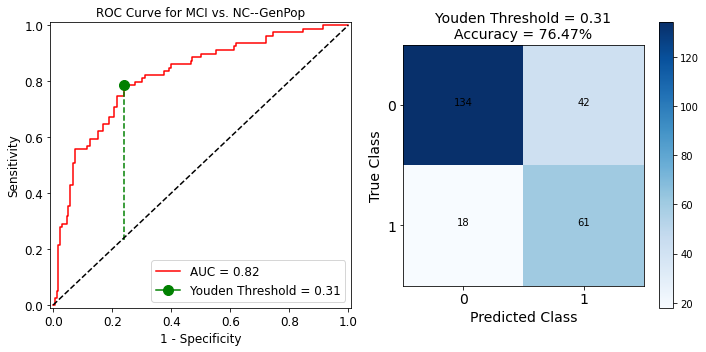

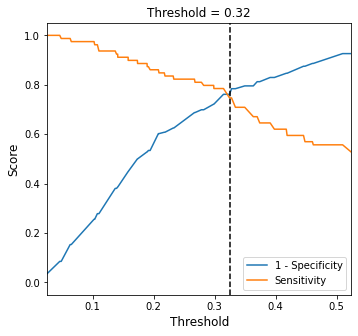

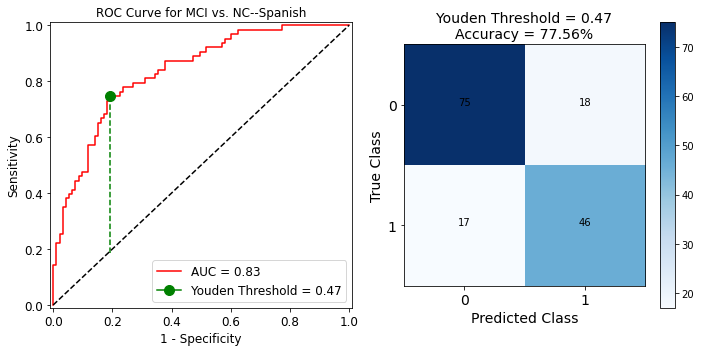

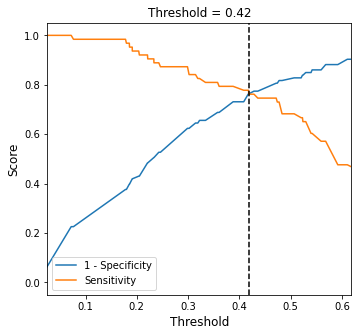

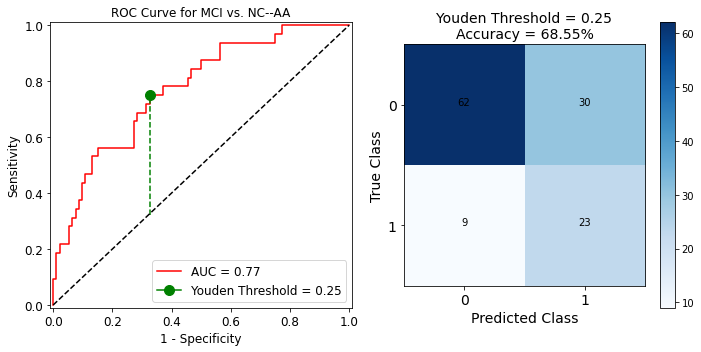

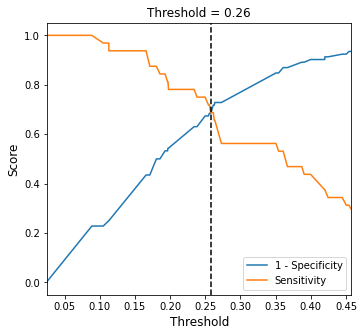

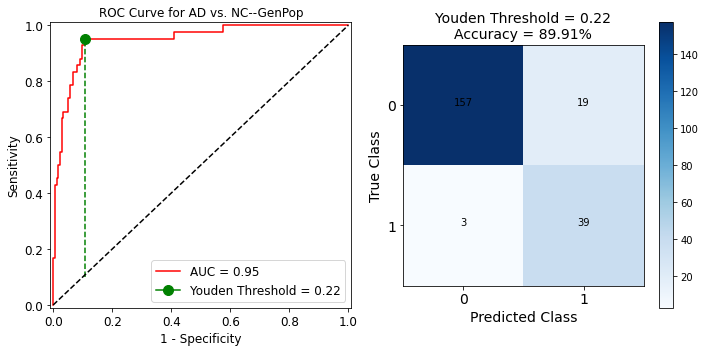

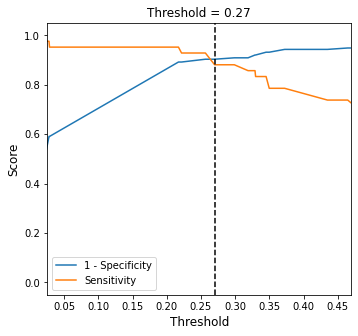

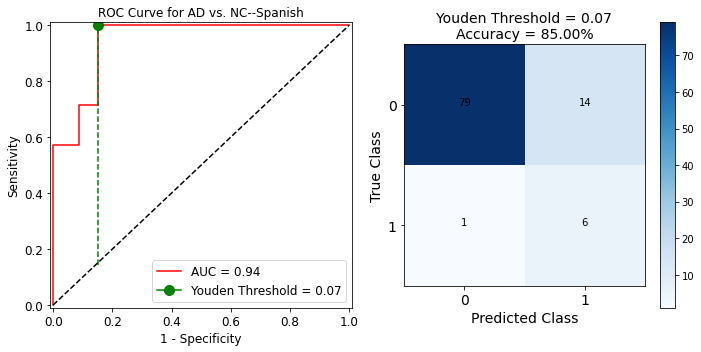

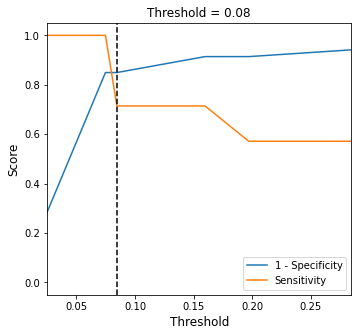

AD vs. NC--AA does not have class 1


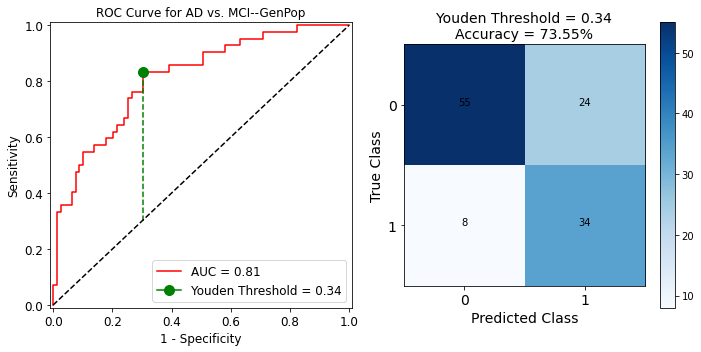

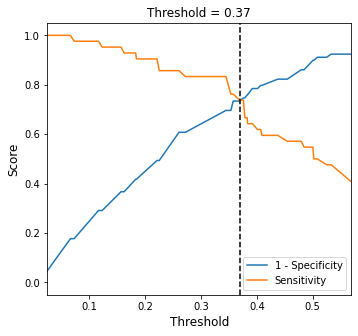

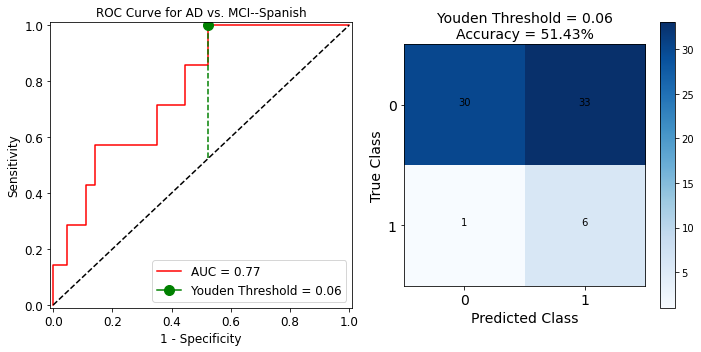

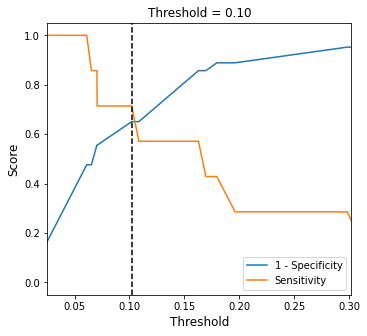

AD vs. MCI--AA does not have class 1


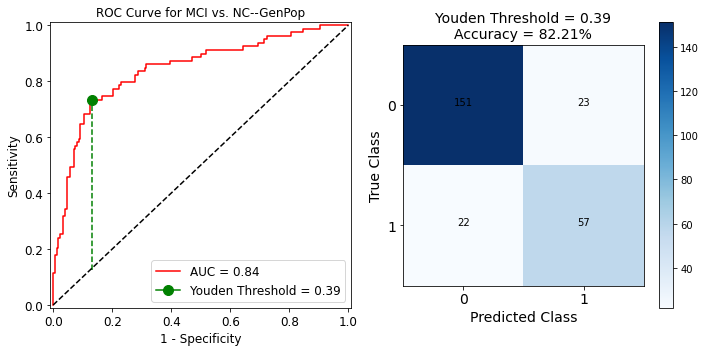

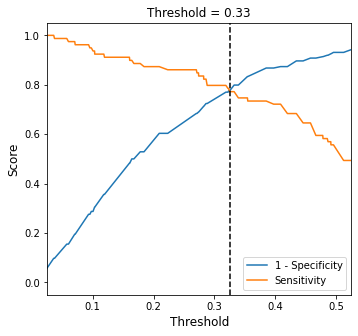

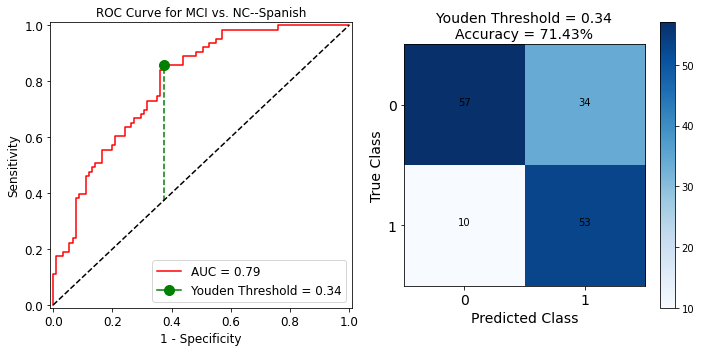

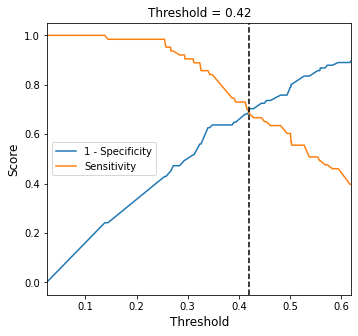

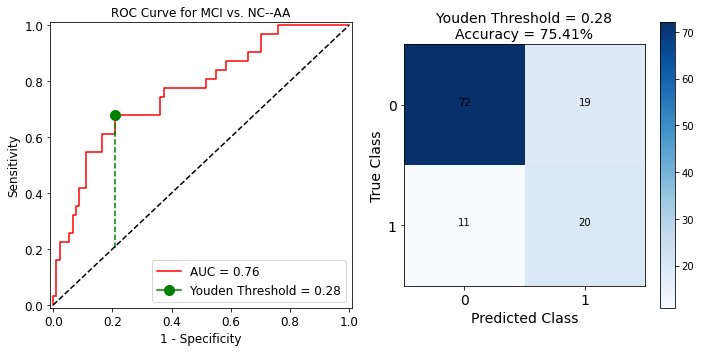

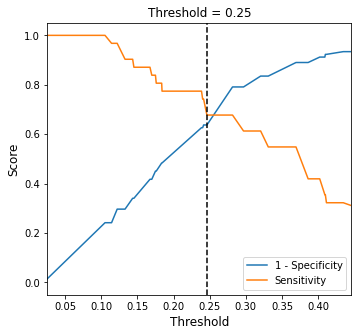

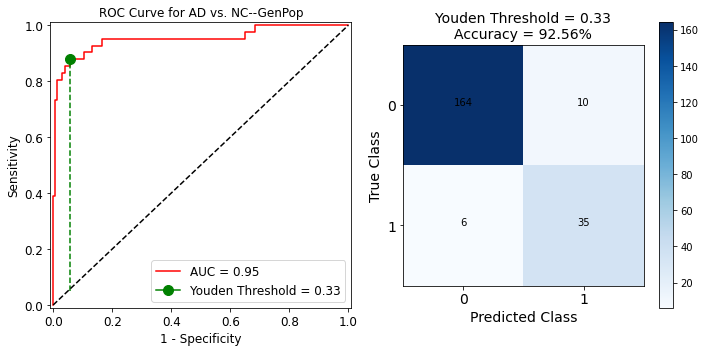

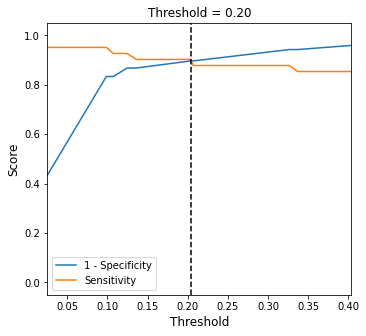

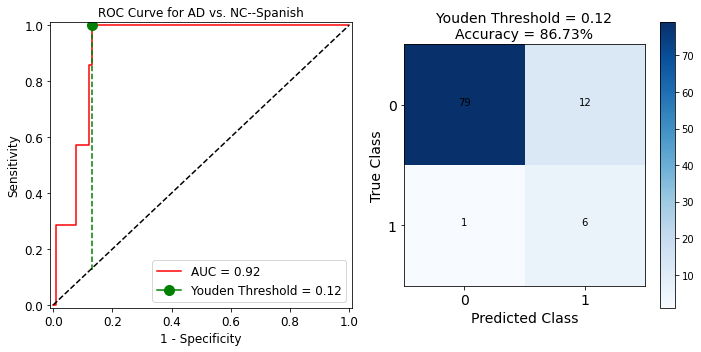

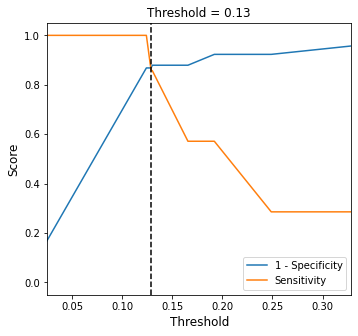

AD vs. NC--AA does not have class 1


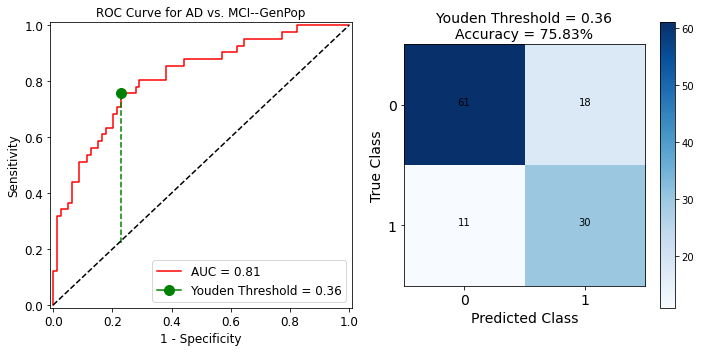

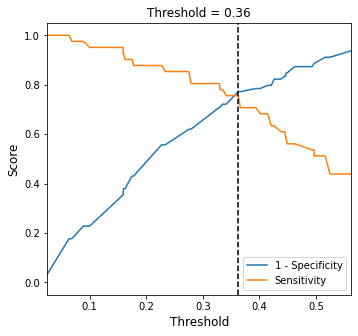

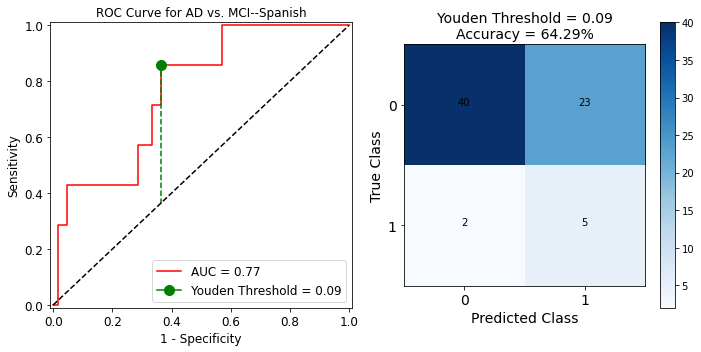

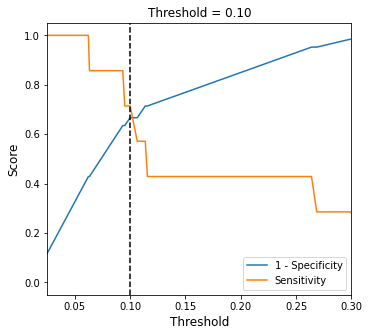

AD vs. MCI--AA does not have class 1


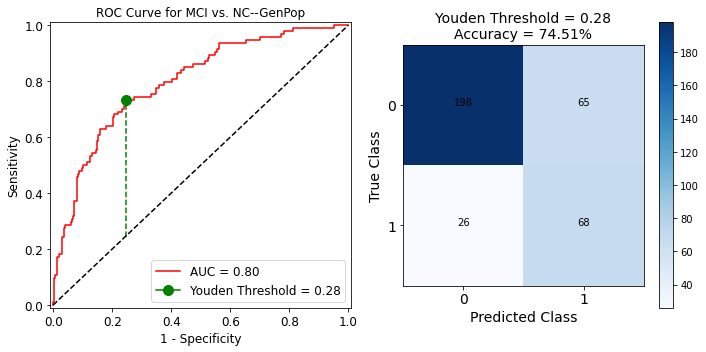

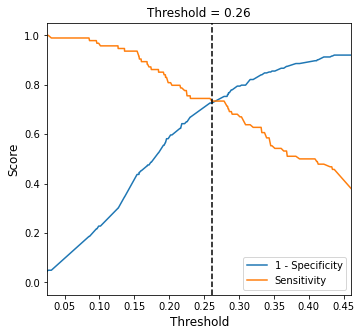

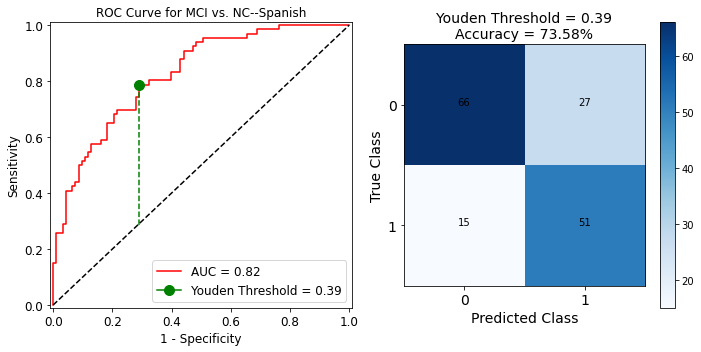

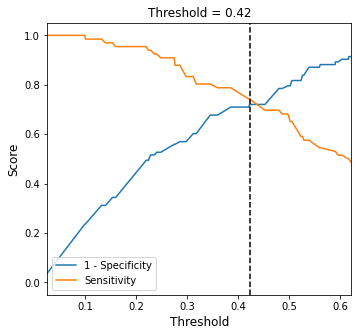

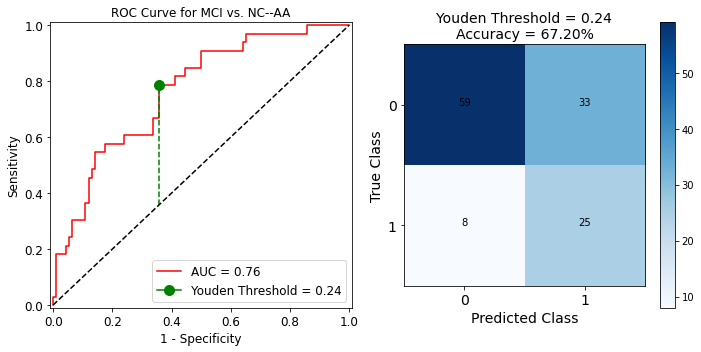

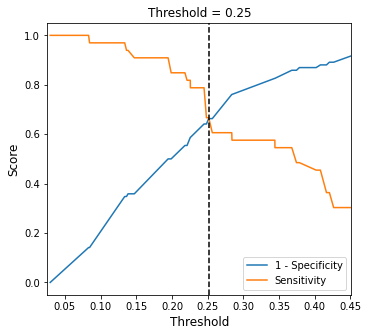

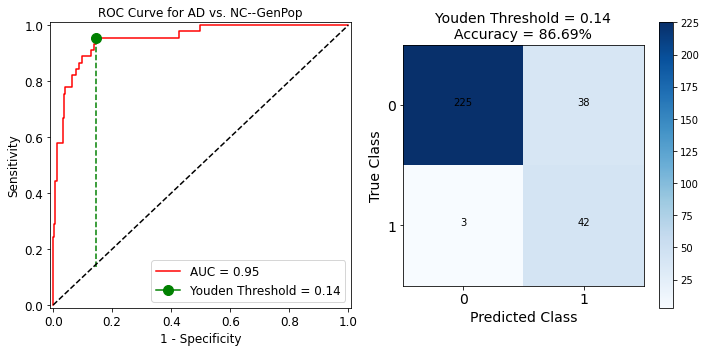

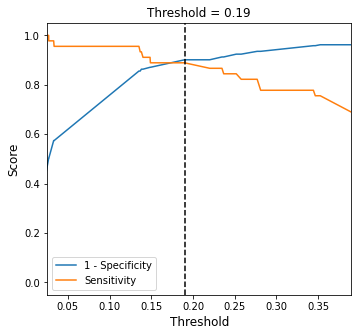

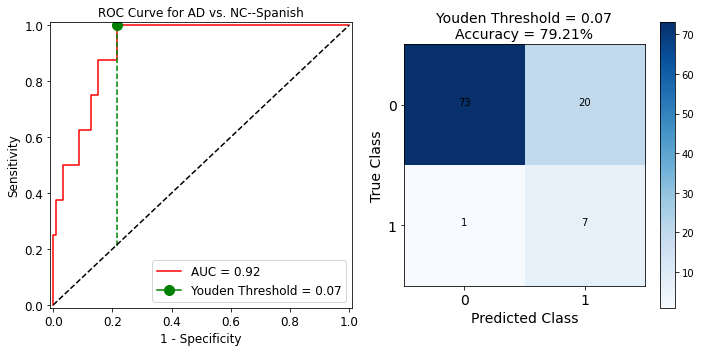

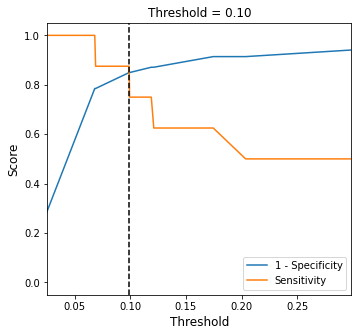

AD vs. NC--AA does not have class 1


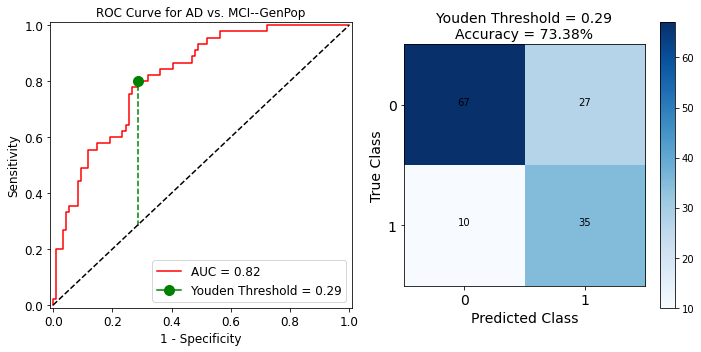

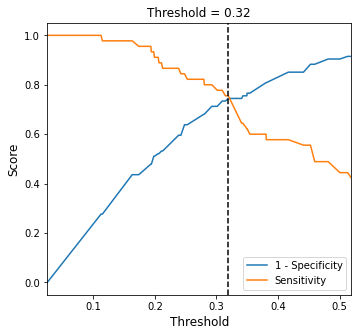

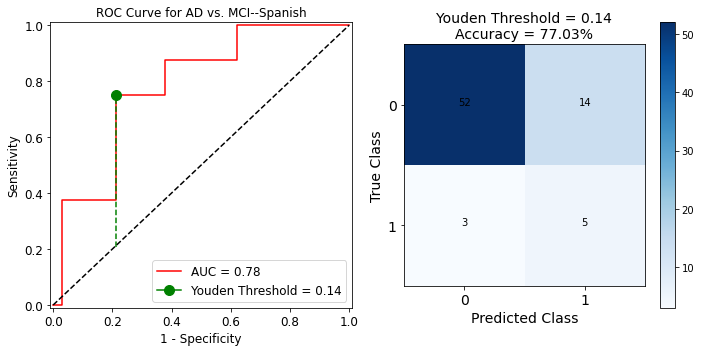

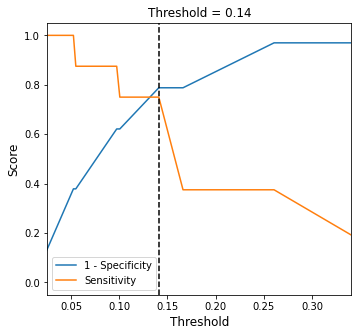

AD vs. MCI--AA does not have class 1


In [ ]:
rv = []
fa =[]
for i in range(3):
  for cg in ['AD','MCI','NC']:
    for cohort in ['GenPop','Spanish','AA']:
      X, y, t = select_subset(df, cg, var1[i], cohort)
      df1 = _threshold_finder(X, y , t)
      rv.append(df1)
    
  temp = pd.concat(rv)
  temp['Corrections'] =names[i]
  fa.append(temp)
all = pd.concat(fa, ignore_index=True)
all['Regression'] = 1

In [ ]:
all

,Title,Accuracy,AUC-ROC,95% CI,AVG Precision,Youden index,"Precision,Recall,F1 at_50",Corrections,Regression
0,MCI vs. NC--GenPop,0.81,0.82,"(0.76, 0.88)",0.66,0.31,"(0.51, 0.82, 0.63)",Age,1
1,MCI vs. NC--Spanish,0.77,0.83,"(0.77, 0.9)",0.78,0.47,"(0.64, 0.79, 0.71)",Age,1
2,MCI vs. NC--AA,0.77,0.77,"(0.67, 0.88)",0.58,0.25,"(0.4, 0.78, 0.53)",Age,1
3,AD vs. NC--GenPop,0.91,0.95,"(0.9, 1.0)",0.84,0.22,"(0.37, 0.95, 0.53)",Age,1
4,AD vs. NC--Spanish,0.96,0.94,"(0.83, 1)",0.72,0.07,"(0.14, 1.0, 0.25)",Age,1
5,AD vs. MCI--GenPop,0.78,0.81,"(0.73, 0.9)",0.72,0.34,"(0.58, 0.83, 0.69)",Age,1
6,AD vs. MCI--Spanish,0.90,0.77,"(0.56, 0.98)",0.36,0.06,"(0.17, 0.86, 0.29)",Age,1
7,MCI vs. NC--GenPop,0.81,0.82,"(0.76, 0.88)",0.66,0.31,"(0.51, 0.82, 0.63)",Fully,1
8,MCI vs. NC--Spanish,0.77,0.83,"(0.77, 0.9)",0.78,0.47,"(0.64, 0.79, 0.71)",Fully,1
9,MCI vs. NC--AA,0.77,0.77,"(0.67, 0.88)",0.58,0.25,"(0.4, 0.78, 0.53)",Fully,1


B) AD vs MCI (c(0,1)) = DCCS + Flanker + LSWM + … + age + sex + education
 


In [ ]:
var2_acs =['cohort_group','cognitive_status','AGE', 'SEX', 'DCCS_ACSScore', 'Flanker_ACSScore',
       'LSWM_ACSScore',  'ORR_ACSScore',  'PCPS_ACSScore',  'PSM_ACSScore', 
       'TPVT_ACSScore','College Degree', 'Graduate Degree', 'High School', 'Less than HS',
       'None', 'Some College']

In [ ]:
var2_ucs =['cohort_group','cognitive_status','AGE', 'SEX', 'DCCS_UCSScore', 'Flanker_UCSScore',
       'LSWM_UCSScore',  'ORR_UCSScore',  'PCPS_UCSScore',  'PSM_UCSScore', 
       'TPVT_UCSScore','College Degree', 'Graduate Degree', 'High School', 'Less than HS',
       'None', 'Some College']

In [ ]:
var2_ftc =['cohort_group','cognitive_status','AGE', 'SEX', 'DCCS_FCTScore', 'Flanker_FCTScore',
       'LSWM_FCTScore',  'ORR_FCTScore',  'PCPS_FCTScore',  'PSM_FCTScore', 
       'TPVT_FCTScore','College Degree', 'Graduate Degree', 'High School', 'Less than HS',
       'None', 'Some College']

In [ ]:
var2=[var2_acs,var2_ftc,var2_ucs]

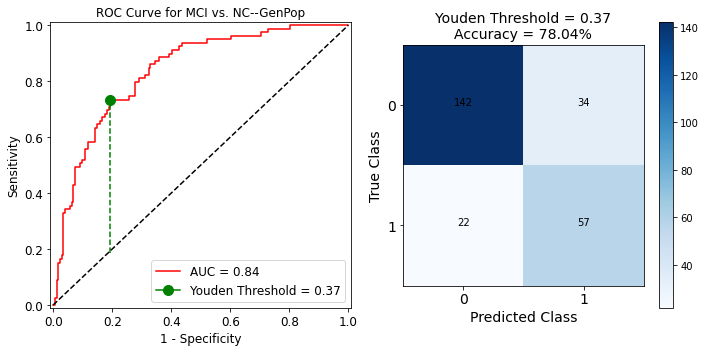

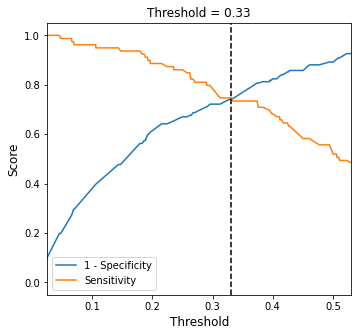

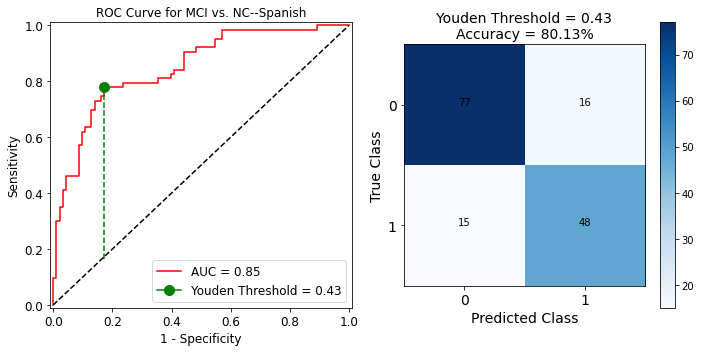

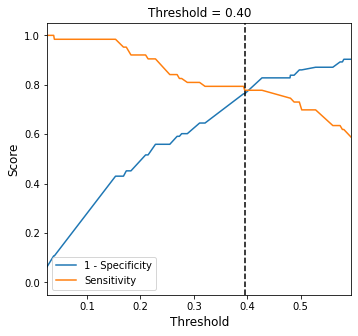

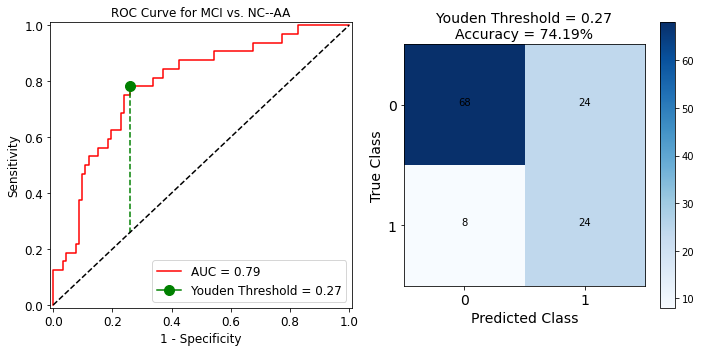

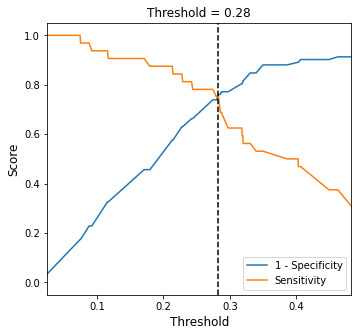

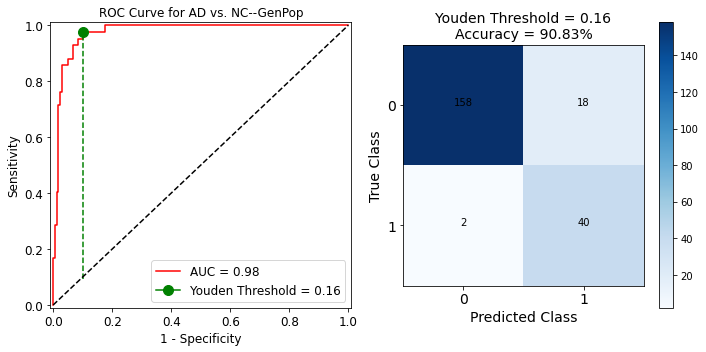

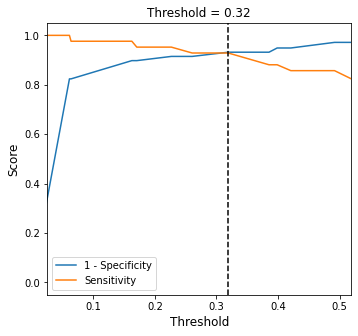

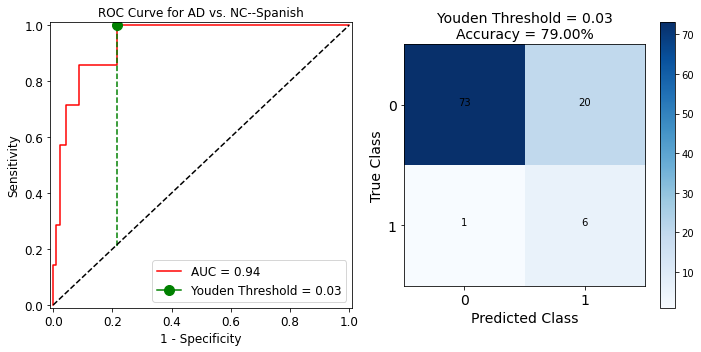

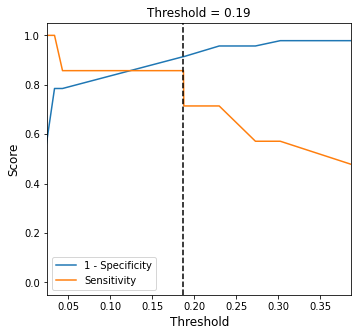

AD vs. NC--AA does not have class 1


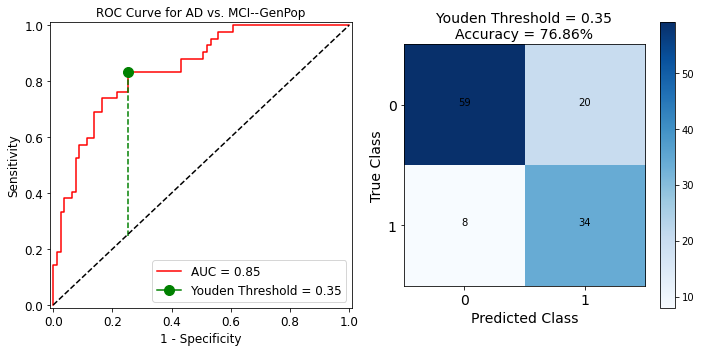

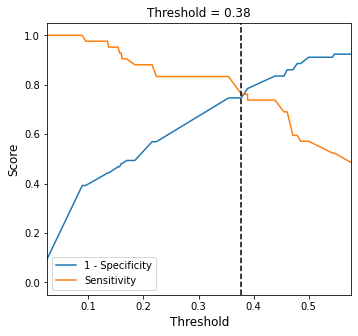

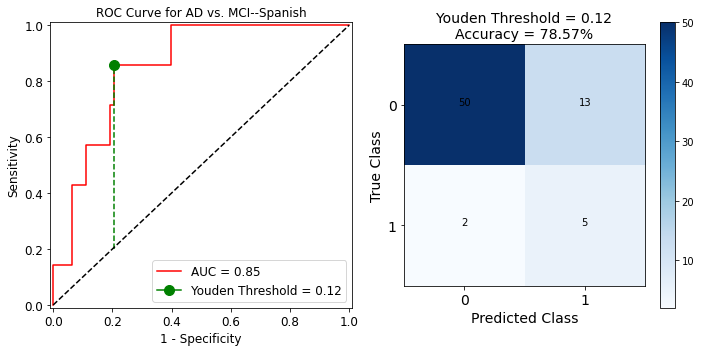

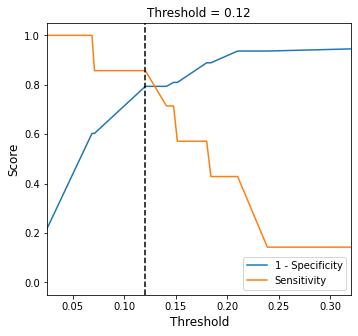

AD vs. MCI--AA does not have class 1


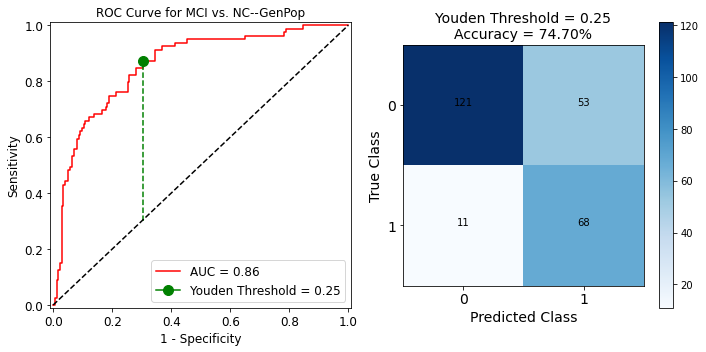

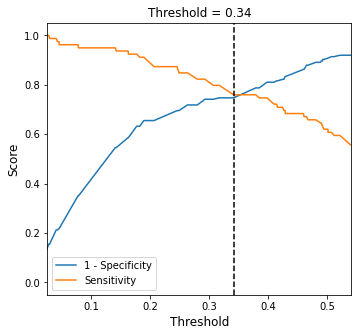

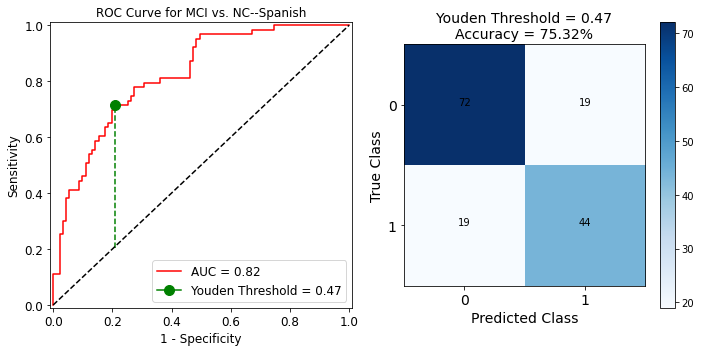

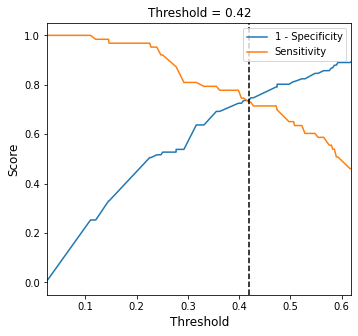

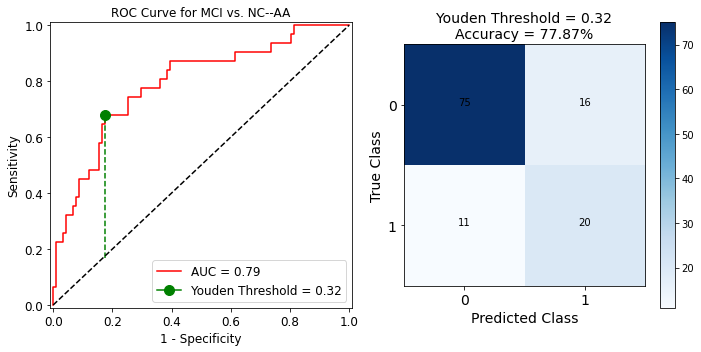

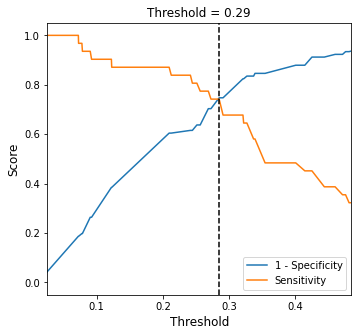

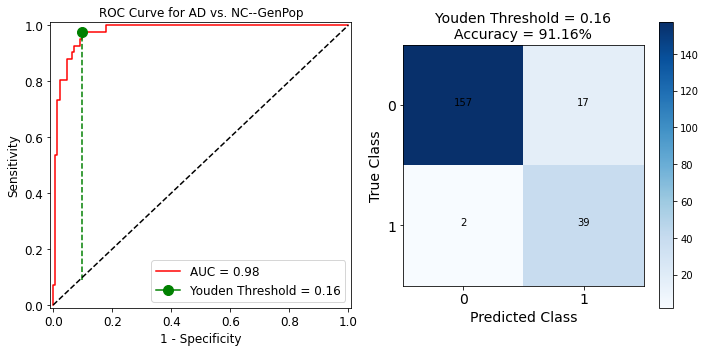

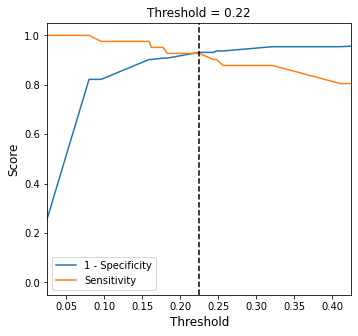

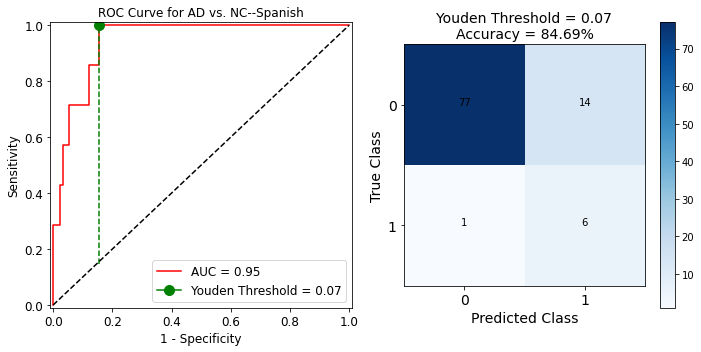

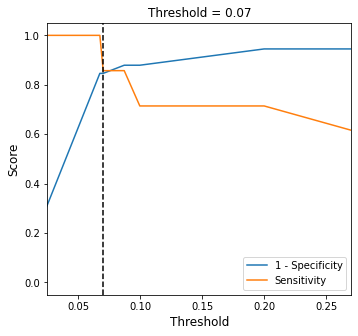

AD vs. NC--AA does not have class 1


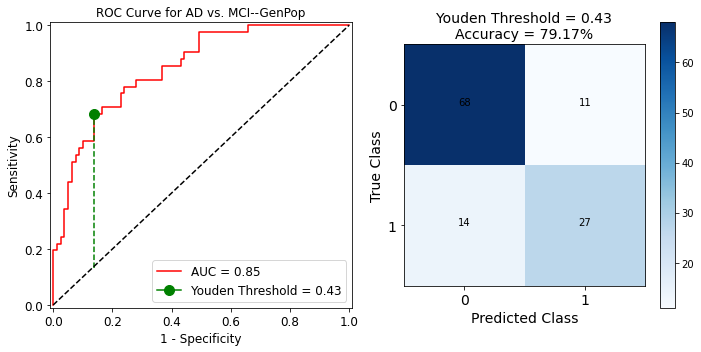

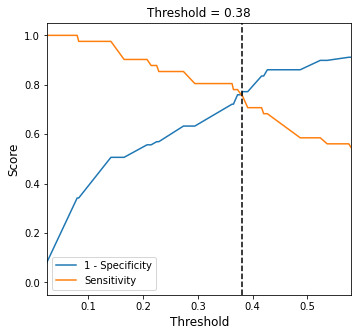

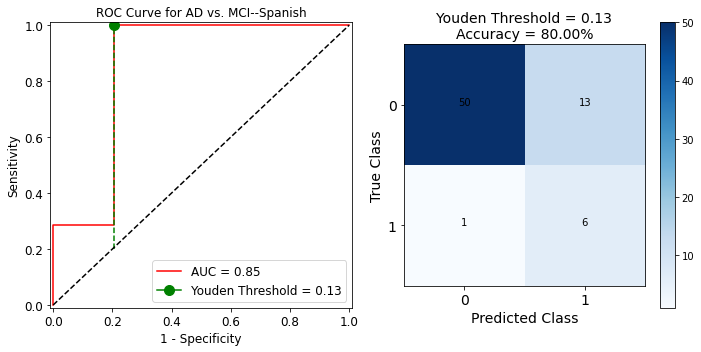

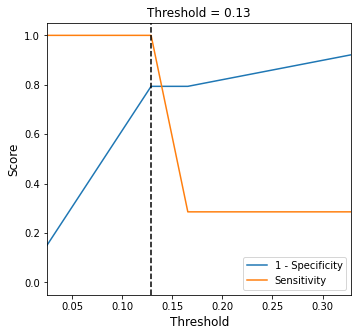

AD vs. MCI--AA does not have class 1


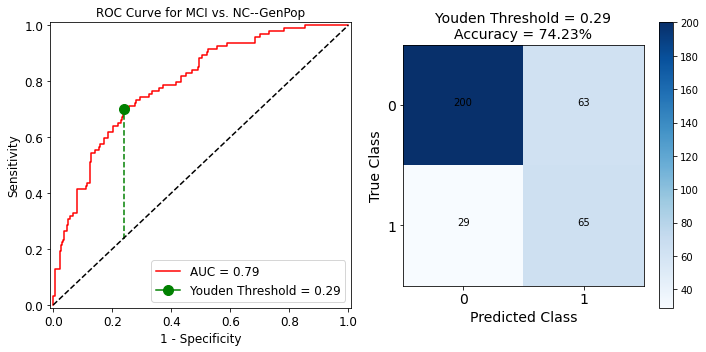

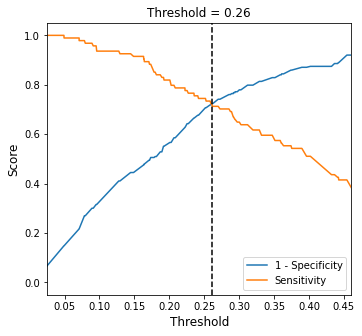

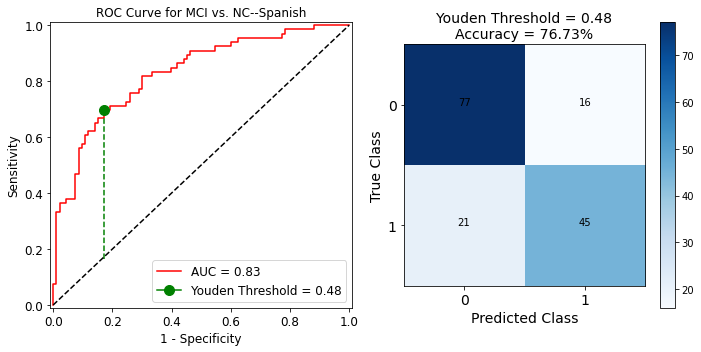

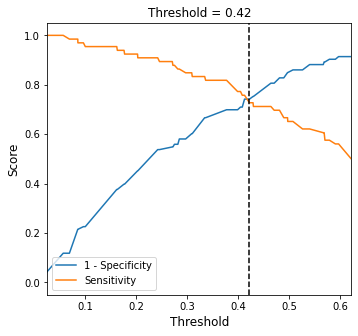

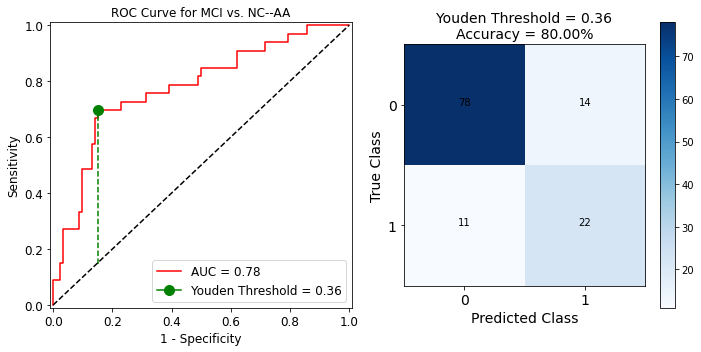

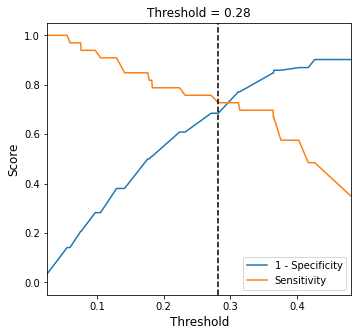

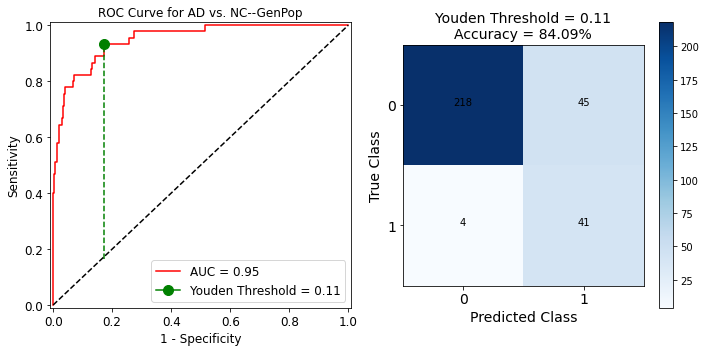

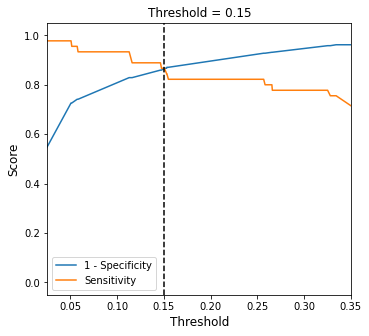

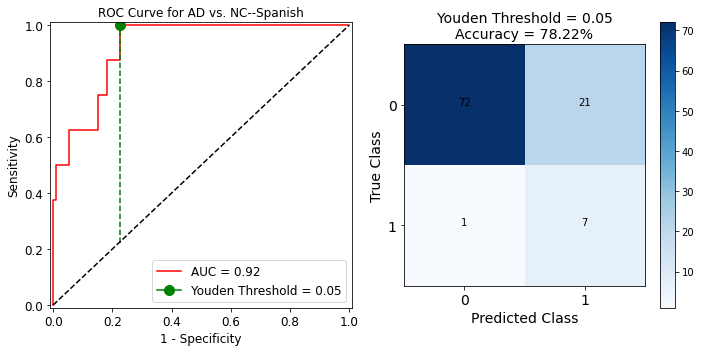

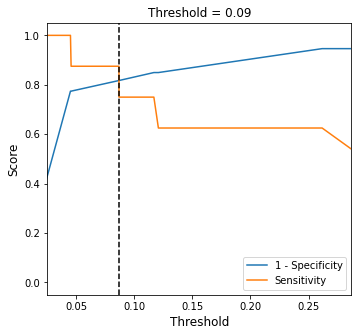

AD vs. NC--AA does not have class 1


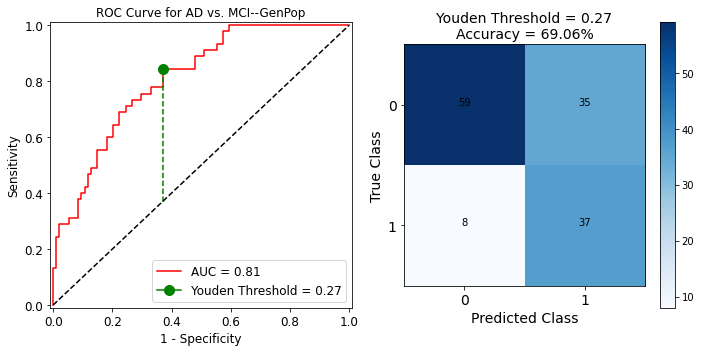

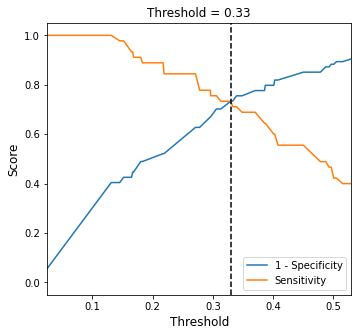

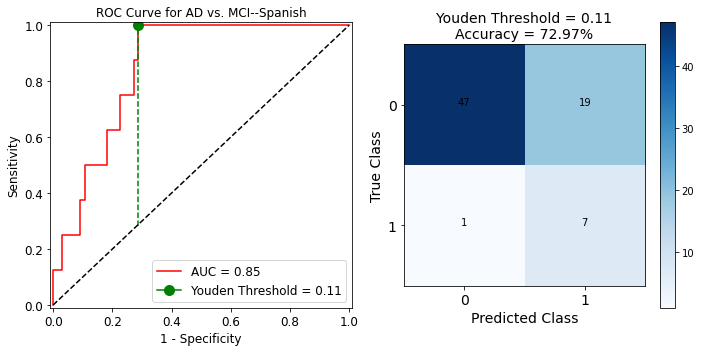

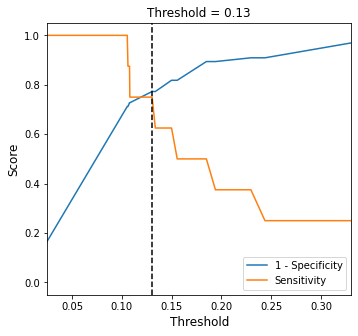

AD vs. MCI--AA does not have class 1


In [ ]:
rv = []
fa =[]
for i in range(3):
  for cg in ['AD','MCI','NC']:
    for cohort in ['GenPop','Spanish','AA']:
      X, y, t = select_subset(df, cg, var2[i], cohort)
      df1 = _threshold_finder(X, y , t)
      rv.append(df1)
    
  temp = pd.concat(rv)
  temp['Corrections'] =names[i]
  fa.append(temp)
all2 = pd.concat(fa, ignore_index=True)
all2['Regression'] = 2

In [ ]:
all2

,Title,Accuracy,AUC-ROC,95% CI,AVG Precision,Youden index,"Precision,Recall,F1 at_50",Corrections,Regression
0,MCI vs. NC--GenPop,0.78,0.84,"(0.78, 0.9)",0.66,0.37,"(0.54, 0.86, 0.66)",Age,2
1,MCI vs. NC--Spanish,0.80,0.85,"(0.78, 0.91)",0.80,0.43,"(0.64, 0.79, 0.71)",Age,2
2,MCI vs. NC--AA,0.73,0.79,"(0.69, 0.89)",0.57,0.27,"(0.44, 0.84, 0.57)",Age,2
3,AD vs. NC--GenPop,0.94,0.98,"(0.94, 1)",0.88,0.16,"(0.39, 1.0, 0.56)",Age,2
4,AD vs. NC--Spanish,0.94,0.94,"(0.82, 1)",0.60,0.03,"(0.14, 1.0, 0.25)",Age,2
5,AD vs. MCI--GenPop,0.79,0.85,"(0.77, 0.93)",0.75,0.35,"(0.58, 0.83, 0.69)",Age,2
6,AD vs. MCI--Spanish,0.91,0.85,"(0.67, 1)",0.42,0.12,"(0.2, 1.0, 0.33)",Age,2
7,MCI vs. NC--GenPop,0.78,0.84,"(0.78, 0.9)",0.66,0.37,"(0.54, 0.86, 0.66)",Fully,2
8,MCI vs. NC--Spanish,0.80,0.85,"(0.78, 0.91)",0.80,0.43,"(0.64, 0.79, 0.71)",Fully,2
9,MCI vs. NC--AA,0.73,0.79,"(0.69, 0.89)",0.57,0.27,"(0.44, 0.84, 0.57)",Fully,2


In [ ]:
#Previously used function

def plot_roc(X,y, t):

    results_df = pd.DataFrame(columns=('Title', 'accuracy','auc-roc', 'avg precision','precision,recall,f1 at_50'))
    
    lr = LogisticRegression(random_state=0).fit(X, y)
    probas = lr.predict_proba(X)
    y_pred_probs = lr.predict_proba(X)[:,1]
    accuracy = round(lr.score(X, y),2)
    #Zip, unzip to ensure corresponding order
    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y), reverse=True))
    results_df.loc[len(results_df)] = [t, accuracy, round(roc_auc_score(y, y_pred_probs),2),
                                    round(average_precision_score(y, y_pred_probs),2),
                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]



    return results_df